In [2]:
import numpy as np
import pandas as pd
import zen
import matplotlib.pyplot as plt

In [3]:
#G = zen.io.gml.read('amazon_reviews_beauty.gml',weight_fxn=lambda x: x['weight'])
G = zen.io.gml.read('amazon_reviews_health.gml',weight_fxn=lambda x: x['weight'])

In [4]:
evc = zen.algorithms.eigenvector_centrality_(G,weighted=True)
evc = evc - np.min(evc)
evc = evc / np.max(evc)

In [5]:
def katz(G,tol=0.01,max_iter=1000,alpha=0.001,beta=1):
    iteration = 0
    centrality = np.zeros(G.num_nodes)
    while iteration < max_iter:
        iteration += 1          # increment iteration count
        centrality_old = centrality.copy()

        for node in G.nodes_():
            Ax = 0
            for neighbor in G.neighbors_(node):
                weight = G.weight_(G.edge_idx_(neighbor,node))
                Ax += np.multiply(centrality[neighbor],weight)

                #Ax += centrality[neighbor]      #exclude weight due to overflow in multiplication

            centrality[node] = np.multiply(alpha,Ax)+beta

        if np.sum(np.abs(np.subtract(centrality,centrality_old))) < tol:
            return centrality


In [6]:
%%time
kc = katz(G,alpha=1e-6) #1e-6
kc = kc - np.min(kc)
kc = kc / np.max(kc)

CPU times: user 34.2 s, sys: 88 ms, total: 34.2 s
Wall time: 34.2 s


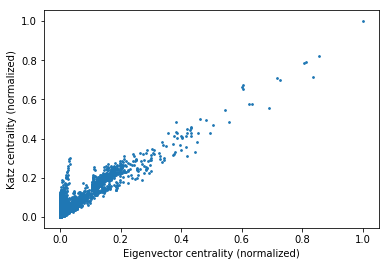

In [7]:
plt.scatter(evc,kc,s=3)
plt.xlabel('Eigenvector centrality (normalized)')
plt.ylabel('Katz centrality (normalized)')
plt.show()

In [28]:
X = np.empty((len(evc),2))
X[:,0] = evc
X[:,1] = kc

#[0,0]s will not be compatible with cosine similarity since they have no magnitude. Add small amount.
s = pd.Series(np.array(np.where(X==0))[0])
X[s[s.duplicated()].values,:] = [1e-9,1e-9]

In [29]:
from sklearn.cluster import AgglomerativeClustering as AC

/home/markditsworth/anaconda2/lib/python2.7/site-packages/_pytest/fixtures.py:844: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  params = attr.ib(convert=attr.converters.optional(tuple))


In [36]:
clusters = AC(n_clusters=2,affinity='cosine',linkage='complete').fit(X)

In [37]:
labels = clusters.labels_
print len(labels)
print len(evc)

25026
25026


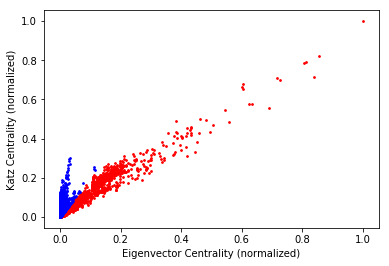

In [41]:
color = ['r','b','g']
for x in [0,1]:
    idx = np.where(labels==x)[0]
    plt.scatter(evc[idx],kc[idx],s=3,color=color[x])
#plt.gca().set_yscale('log')
#plt.gca().set_xscale('log')
#plt.gca().set_xlim([1e-7,1])
#plt.gca().set_ylim([1e-4,1])
plt.xlabel('Eigenvector Centrality (normalized)')
plt.ylabel('Katz Centrality (normalized)')
plt.show()

In [40]:
classes = {}
for c in [0,1]:
    idxes = np.where(labels==c)[0]
    classes[c] = [G.node_object(i) for i in idxes]

def modularity(G,classDict,classList):
    Q = zen.algorithms.modularity(G,classDict)
    # Maximum Modularity
    count=0.0
    for e in G.edges():
        n1 = G.node_idx(e[0])
        n2 = G.node_idx(e[1])
        if classList[n1] == classList[n2]:
            count += 1
    same = count / G.num_edges
    rand = same - Q
    qmax = 1 - rand
    return Q, qmax

q,qmax = modularity(G,classes,labels)
print q
print qmax
print q/qmax

0.392555955116
0.485992156846
0.80774133818


In [44]:
for x in classes:
    print len(classes[x])
print G.num_nodes

2615
22411
25026
